# Importando dados 

In [1]:
# pacotes
#%matplotlib inline

from bs4 import BeautifulSoup
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Após realizarmos o scrape do site Transfer Market temos os conjuntos de dados a respeito da transferências de jogadores para diferentes temporadas. 

In [2]:
# vamos pegar todas as transferencias e colocar em apenas um arquivo de dados

li = []

for year in ['2014', '2015', '2017', '2018', '2019', '2020', '2021']:
    for league in ['english_premier_league', 
                   'french_ligue_1',
                  'german_bundesliga_1',
                  'italian_serie_a',
                  'portugese_liga_nos',
                  'spanish_primera_division']:
        
        frame = pd.read_csv(f'transfer-market/data/{year}/{league}.csv')
        
        li.append(frame)
        
        
transfers_df = pd.concat(li, axis=0, ignore_index=True)

transfers_df.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,Arsenal FC,Alexis Sánchez,25.0,Centre-Forward,Barcelona,£38.25m,in,Summer,38.25,Premier League,2014,2014/2015
1,Arsenal FC,Calum Chambers,19.0,Right-Back,Southampton,£18.21m,in,Summer,18.21,Premier League,2014,2014/2015
2,Arsenal FC,Danny Welbeck,23.0,Centre-Forward,Man Utd,£18.00m,in,Summer,18.00,Premier League,2014,2014/2015
3,Arsenal FC,Mathieu Debuchy,28.0,Right-Back,Newcastle,£13.50m,in,Summer,13.50,Premier League,2014,2014/2015
4,Arsenal FC,David Ospina,25.0,Goalkeeper,OGC Nice,£3.60m,in,Summer,3.60,Premier League,2014,2014/2015


Agora precisamos obter os dados das temporadas dos jogadores dessa lista. 

Para isso, vamos ter que minerar os dados do site *UnderStat.com*

O primeiro passo será obter a lista de todos os jogadores da **Premier League** cadastrados no site, com seus respectivos nomes e id. O nome do jogador será fundamental para podermos conectar a tabela das temporadas com a tabela de transferências que acabamos de obter. Enquanto isso, o *id* de um jogador é a forma do *UnderStat* reconhecer cada jogador em seu banco de dados, assim cada jogador possui um valor único de *id* que o identifica. 

In [3]:
#url contendo todas as infos a respeito da English Premier League (EPL)
url = 'https://understat.com/league/EPL'

soup = BeautifulSoup(requests.get(url).content, 'lxml')

div_soup = soup.find_all('div', class_ = 'page-wrapper')[0].find_all('script')

# a tabela que queremos está como segundo indice da lista
div_soup[2]

<script>
	var playersData	= JSON.parse('\x5B\x7B\x22id\x22\x3A\x221250\x22,\x22player_name\x22\x3A\x22Mohamed\x20Salah\x22,\x22games\x22\x3A\x2220\x22,\x22time\x22\x3A\x221786\x22,\x22goals\x22\x3A\x2216\x22,\x22xG\x22\x3A\x2215.608175069093704\x22,\x22assists\x22\x3A\x229\x22,\x22xA\x22\x3A\x226.22314802929759\x22,\x22shots\x22\x3A\x2280\x22,\x22key_passes\x22\x3A\x2240\x22,\x22yellow_cards\x22\x3A\x221\x22,\x22red_cards\x22\x3A\x220\x22,\x22position\x22\x3A\x22F\x22,\x22team_title\x22\x3A\x22Liverpool\x22,\x22npg\x22\x3A\x2214\x22,\x22npxG\x22\x3A\x2213.324668571352959\x22,\x22xGChain\x22\x3A\x2222.21259716153145\x22,\x22xGBuildup\x22\x3A\x227.717494197189808\x22\x7D,\x7B\x22id\x22\x3A\x226854\x22,\x22player_name\x22\x3A\x22Diogo\x20Jota\x22,\x22games\x22\x3A\x2221\x22,\x22time\x22\x3A\x221577\x22,\x22goals\x22\x3A\x2210\x22,\x22xG\x22\x3A\x2212.519980128854513\x22,\x22assists\x22\x3A\x221\x22,\x22xA\x22\x3A\x223.8385497368872166\x22,\x22shots\x22\x3A\x2259\x22,\x22key_passes\x22\x3A

In [4]:
# remove os símbolos para convertermos os dados para json
div_soup = div_soup[2].string

ind_start = div_soup.index("('") + 2
ind_end = div_soup.index("')") 

json_data = div_soup[ind_start:ind_end]
json_data = json_data.encode('utf8').decode('unicode_escape')

# converte a string para formato json
data = json.loads(json_data)

In [5]:
data

[{'id': '1250',
  'player_name': 'Mohamed Salah',
  'games': '20',
  'time': '1786',
  'goals': '16',
  'xG': '15.608175069093704',
  'assists': '9',
  'xA': '6.22314802929759',
  'shots': '80',
  'key_passes': '40',
  'yellow_cards': '1',
  'red_cards': '0',
  'position': 'F',
  'team_title': 'Liverpool',
  'npg': '14',
  'npxG': '13.324668571352959',
  'xGChain': '22.21259716153145',
  'xGBuildup': '7.717494197189808'},
 {'id': '6854',
  'player_name': 'Diogo Jota',
  'games': '21',
  'time': '1577',
  'goals': '10',
  'xG': '12.519980128854513',
  'assists': '1',
  'xA': '3.8385497368872166',
  'shots': '59',
  'key_passes': '25',
  'yellow_cards': '1',
  'red_cards': '0',
  'position': 'F S',
  'team_title': 'Liverpool',
  'npg': '10',
  'npxG': '12.519980128854513',
  'xGChain': '19.360652767121792',
  'xGBuildup': '5.775763585232198'},
 {'id': '755',
  'player_name': 'Jamie Vardy',
  'games': '16',
  'time': '1325',
  'goals': '9',
  'xG': '6.063936270773411',
  'assists': '1',
 

A partir da tabela retirada do site, vamos criar um dataset com as variáveis ***id*** e ***player_name***

In [6]:
players_name = []; players_id = []

for player in range(len(data)):
    players_name.append(data[player]['player_name'])
    players_id.append(data[player]['id'])

li = [players_id,
     players_name]    
    
players = pd.DataFrame(li).T.rename(columns= {0: 'id', 1: 'player_name'})

In [7]:
players.head()

,id,player_name
0,1250,Mohamed Salah
1,6854,Diogo Jota
2,755,Jamie Vardy
3,453,Son Heung-Min
4,531,Michail Antonio


Agora, precisamos ser capazes de, ao recebermos o ***id*** de um jogador, retornar as estatísticas de suas temporadas segundo o *UnderStat*. E então, poderemos apenas percorrer o *DataFrame* ***players*** aplicando nosso método de obtenção das estatísticas, assim retornando as estatísticas de todos jogadores inscritos no campeonato.

In [8]:
# cria funcao para obter os dados das seasons de um jogador

def get_season(id_player, player_name):
    # url da pagina do understat do jogador
    url = 'https://understat.com/player/{}'.format(id_player)
    
    # cria um objeto BeatifulSoup com o html da url
    soup = BeautifulSoup(requests.get(url).content, 'lxml')

    # seleciona as partes do html contendo apenas os dados sobre as últimas temporadas do jogador
    strings = soup.find_all('script')[1].string

    # seleciona apenas a parte da string da tabela para convertermos os dados para json
    ind_start = strings.index("('") + 2
    ind_end = strings.index("')") 

    json_data = strings[ind_start:ind_end].encode('utf8').decode('unicode_escape')

    # converte a string para formato json
    data = json.loads(json_data)
    
    # converte a tabela json para um dicionario de arrays
    x_variables = {'id': id_player,
                   'player_name': player_name,
                   'position': [],
                   'games': [], 
                   'season': [], 
                   'team': [], 
                   'goals': [], 
                   'shots': [], 
                   'xG': [], 
                   'assists': [], 
                   'xA': [], 
                   'key_passes': [],
                  'yellow': [],
                  'red': [],
                   'npg': [],
                   'npxG': [],
                   'xGChain': [],
                   'xGBuildup': []}

    for season in range(len(data['season'])):
        for key in data['season'][season]:
            for x in x_variables:
                if key == x:
                    x_variables[x].append(data['season'][season][key])
                    
    return pd.DataFrame(x_variables)

In [9]:
# dados das temporadas do Diogo Jota
get_season(6854, 'Diogo Jota')

,id,player_name,position,games,season,team,goals,shots,xG,assists,xA,key_passes,yellow,red,npg,npxG,xGChain,xGBuildup
0,6854,Diogo Jota,FW,21,2021,Liverpool,10,59,12.519980128854513,1,3.8385497368872166,25,1,0,10,12.519980128854513,19.360652767121792,5.775763585232198
1,6854,Diogo Jota,Sub,19,2020,Liverpool,9,46,7.05772053822875,0,1.7625210750848055,12,2,0,9,7.05772053822875,10.972974702715874,4.0760964918881655
2,6854,Diogo Jota,FW,34,2019,Wolverhampton Wanderers,7,69,12.017675075680017,1,2.6425623558461666,29,4,0,7,12.017675075680017,16.149932712316513,4.098007360473275
3,6854,Diogo Jota,FWL,33,2018,Wolverhampton Wanderers,9,58,8.907186842523515,5,5.536081537604332,27,11,0,9,8.907186842523515,16.1504292441532,4.578139785677195


In [10]:
# cria uma função para obter os dados das temporadas de múltiplos jogadores

def get_multiple_seasons(players_id_list, players_names):
    # itera entre os jogadores usando a funcao get_season para obter a season de um jogador
    li = []

    count = 0
    while count < len(players_id_list):
        df_player = get_season(players_id_list[count], players_names[count])

        li.append(df_player)

        # printa qual a porcentagem de conclusao do trabalho
        count += 1
        print(f'{count/len(players_id_list) * 100} %')
    
    # transforma a lista de temporadas dos jogadores em um único DataFrame
    df = pd.concat(li, axis=0, ignore_index=True)
    
    return df

In [11]:
# Obtem os dados das temporadas do Diogo Jota e do Mohamed Salah 
get_multiple_seasons(players.id[0:2], players.player_name[0:2])

50.0 %
100.0 %


,id,player_name,position,games,season,team,goals,shots,xG,assists,xA,key_passes,yellow,red,npg,npxG,xGChain,xGBuildup
0,1250,Mohamed Salah,FWR,20,2021,Liverpool,16,80,15.608175069093704,9,6.22314802929759,40,1,0,14,13.324668571352959,22.21259716153145,7.717494197189808
1,1250,Mohamed Salah,FWR,37,2020,Liverpool,22,126,20.250846637412906,5,6.528526101261377,55,0,0,16,15.683833638206124,28.968233548104763,9.800235655158758
2,1250,Mohamed Salah,FWR,34,2019,Liverpool,19,132,20.66331870108843,10,8.72604252398014,60,1,0,16,18.379812128841877,31.37419793009758,8.42502685263753
3,1250,Mohamed Salah,FWR,38,2018,Liverpool,22,137,21.79245018400252,8,10.468589510768652,68,1,0,19,19.508943611755967,31.780298396945,7.865945274010301
4,1250,Mohamed Salah,FWR,36,2017,Liverpool,32,143,25.136502970010042,10,8.344477602280676,62,1,0,31,23.6141653098166,35.301465447992086,5.898578152060509
5,1250,Mohamed Salah,FWR,31,2016,Roma,15,80,13.411626555025578,11,9.63362380117178,71,2,0,15,13.411626555025578,29.46748649328947,9.299841643311083
6,1250,Mohamed Salah,FWL,34,2015,Roma,14,72,9.377116854302585,6,7.0688703786581755,63,1,1,14,9.377116854302585,23.043303050100803,10.797392231412232
7,1250,Mohamed Salah,Sub,16,2014,Fiorentina,6,29,3.814865604043007,3,1.9356205612421036,30,0,0,6,3.814865604043007,7.404609017074108,2.628024946898222
8,1250,Mohamed Salah,Sub,3,2014,Chelsea,0,2,0.502302423119545,0,0.02637448161840439,1,0,0,0,0.502302423119545,0.5454844385385513,0.01680753380060196
9,6854,Diogo Jota,FW,21,2021,Liverpool,10,59,12.519980128854513,1,3.8385497368872166,25,1,0,10,12.519980128854513,19.360652767121792,5.775763585232198


Agora estamos prontos para minerar todos os dados da Premier League através do site UnderStat com nossas funções.

No entanto, devido ao elevado custo computacional de obter os dados de várias temporadas para todos jogadores inscritos no campeonato inglês vamos rodar as nossas funções em um programa separado. Assim, não precisaremos minerar os dados todas as vezes que rodarmos esse notebook. 

Uma vez rodado o programa com nossas funções, podemos apenas importar o conjunto de dados salvos. 

In [12]:
# lendo os dados salvos no arquivo understat.csv
understat_epl = pd.read_csv('understat_epl.csv')

understat_epl.head()

,Unnamed: 0,id,player_name,position,games,season,team,goals,shots,xG,assists,xA,key_passes,yellow,red,npg,npxG,xGChain,xGBuildup
0,0,1250,Mohamed Salah,FWR,20,2021,Liverpool,16,80,15.608175,9,6.223148,40,1,0,14,13.324669,22.212597,7.717494
1,1,1250,Mohamed Salah,FWR,37,2020,Liverpool,22,126,20.250847,5,6.528526,55,0,0,16,15.683834,28.968234,9.800236
2,2,1250,Mohamed Salah,FWR,34,2019,Liverpool,19,132,20.663319,10,8.726043,60,1,0,16,18.379812,31.374198,8.425027
3,3,1250,Mohamed Salah,FWR,38,2018,Liverpool,22,137,21.792450,8,10.468590,68,1,0,19,19.508944,31.780298,7.865945
4,4,1250,Mohamed Salah,FWR,36,2017,Liverpool,32,143,25.136503,10,8.344478,62,1,0,31,23.614165,35.301465,5.898578


In [13]:
# remove a coluna unnamed
understat_epl.drop('Unnamed: 0', axis=1, inplace=True)

In [14]:
understat_epl.columns

Index(['id', 'player_name', 'position', 'games', 'season', 'team', 'goals',
       'shots', 'xG', 'assists', 'xA', 'key_passes', 'yellow', 'red', 'npg',
       'npxG', 'xGChain', 'xGBuildup'],
      dtype='object')

In [15]:
understat_epl.dtypes

id               int64
player_name     object
position        object
games            int64
season           int64
team            object
goals            int64
shots            int64
xG             float64
assists          int64
xA             float64
key_passes       int64
yellow           int64
red              int64
npg              int64
npxG           float64
xGChain        float64
xGBuildup      float64
dtype: object

Vamos agora ajustar as informações das colunas do DataFrame *df* para ficarem nos formatos corretos

In [16]:
transfers_df.dtypes

club_name              object
player_name            object
age                   float64
position               object
club_involved_name     object
fee                    object
transfer_movement      object
transfer_period        object
fee_cleaned           float64
league_name            object
year                    int64
season                 object
dtype: object

# Concatenando os DataFrames

In [17]:
transfers_df.head(1)

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,Arsenal FC,Alexis Sánchez,25.0,Centre-Forward,Barcelona,£38.25m,in,Summer,38.25,Premier League,2014,2014/2015


In [18]:
understat_epl.head(1)

,id,player_name,position,games,season,team,goals,shots,xG,assists,xA,key_passes,yellow,red,npg,npxG,xGChain,xGBuildup
0,1250,Mohamed Salah,FWR,20,2021,Liverpool,16,80,15.608175,9,6.223148,40,1,0,14,13.324669,22.212597,7.717494


Para podermos unir as duas tabelas vamos ter de concatená-las baseadas no nome do jogador e do ano. As duas colunas unicamente relacionam os elementos entre as tabelas. No entanto, para que referente à transferência tenhamos os dados da temporada **ANTERIOR**, devemos alterar a coluna *year* da tabela de transferências retirando 1 ano de cada linha.

In [19]:
# ajusta o ano na tabela transfers_df para recuperar os dados da temporada ANTES da transferência
transfers_df['year'] = transfers_df['year'].apply(lambda x: x - 1)

In [20]:
# Une as duas tabelas usando como primary key as colunas ['player_name', 'year']
# apenas jogadores presentes nas duas tabelas são adicionados (how='inner')
df = pd.merge(transfers_df, understat_epl, left_on = ['player_name', 'year'], right_on = ['player_name', 'season'],  how='inner')

df.head()

,club_name,player_name,age,position_x,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,...,xG,assists,xA,key_passes,yellow,red,npg,npxG,xGChain,xGBuildup
0,Chelsea FC,Asmir Begovic,28.0,Goalkeeper,Stoke City,£9.90m,in,Summer,9.9,Premier League,...,0.067008,0,0.029391,1,3,0,0,0.067008,1.855953,1.826562
1,Stoke City,Asmir Begovic,28.0,Goalkeeper,Chelsea,£9.90m,out,Summer,9.9,Premier League,...,0.067008,0,0.029391,1,3,0,0,0.067008,1.855953,1.826562
2,Chelsea FC,Andreas Christensen,19.0,Centre-Back,Chelsea U21,-,in,Summer,0.0,Premier League,...,0.000000,0,0.000000,0,0,0,0,0.000000,0.016525,0.016525
3,Chelsea FC,Andreas Christensen,19.0,Centre-Back,Bor. M'gladbach,loan transfer,out,Summer,NaN,Premier League,...,0.000000,0,0.000000,0,0,0,0,0.000000,0.016525,0.016525
4,Borussia Mönchengladbach,Andreas Christensen,19.0,Centre-Back,Chelsea,loan transfer,in,Summer,NaN,1 Bundesliga,...,0.000000,0,0.000000,0,0,0,0,0.000000,0.016525,0.016525


In [21]:
# remove colunas desnecessárias ['league_name', 'transfer_period'] e valores repetidos (in e out)
df = df.loc[df.transfer_movement == 'out'].drop(['transfer_movement', 'league_name', 'transfer_period'], axis = 1).reset_index(drop=True)

df.head()

,club_name,player_name,age,position_x,club_involved_name,fee,fee_cleaned,year,season_x,id,...,xG,assists,xA,key_passes,yellow,red,npg,npxG,xGChain,xGBuildup
0,Stoke City,Asmir Begovic,28.0,Goalkeeper,Chelsea,£9.90m,9.9,2014,2015/2016,694,...,0.067008,0,0.029391,1,3,0,0,0.067008,1.855953,1.826562
1,Chelsea FC,Andreas Christensen,19.0,Centre-Back,Bor. M'gladbach,loan transfer,NaN,2014,2015/2016,200,...,0.000000,0,0.000000,0,0,0,0,0.000000,0.016525,0.016525
2,Chelsea FC,Nathan Aké,20.0,Centre-Back,Watford,loan transfer,NaN,2014,2015/2016,579,...,0.000000,0,0.000000,0,0,0,0,0.000000,0.072314,0.072314
3,Watford FC,Nathan Aké,21.0,Centre-Back,Chelsea,"End of loanMay 31, 2016",0.0,2014,2015/2016,579,...,0.000000,0,0.000000,0,0,0,0,0.000000,0.072314,0.072314
4,Chelsea FC,Mohamed Salah,23.0,Right Winger,AS Roma,Loan fee:£4.50m,4.5,2014,2015/2016,1250,...,3.814866,3,1.935621,30,0,0,6,3.814866,7.404609,2.628025


# Cleaning Data

Primeiro vamos verificar a existência de valores faltantes no nosso banco de dados.

In [22]:
for column in df.columns:
    print('{} : {}'.format(column, df[column].isnull().values.any()))

club_name : False
player_name : False
age : False
position_x : False
club_involved_name : False
fee : False
fee_cleaned : True
year : False
season_x : False
id : False
position_y : False
games : False
season_y : False
team : False
goals : False
shots : False
xG : False
assists : False
xA : False
key_passes : False
yellow : False
red : False
npg : False
npxG : False
xGChain : False
xGBuildup : False


Apenas na coluna *fee_cleaned* encontramos valores faltantes. Vamos dar uma olhada mais a fundo. 

In [23]:
df.loc[df.fee_cleaned.isnull()].fee.unique()

array(['loan transfer', 'free transfer', '?'], dtype=object)

In [24]:
df.loc[df.fee == '?']

,club_name,player_name,age,position_x,club_involved_name,fee,fee_cleaned,year,season_x,id,...,xG,assists,xA,key_passes,yellow,red,npg,npxG,xGChain,xGBuildup
279,Portimonense SC,Fernandinho,24.0,Left Midfield,CD Fátima,?,NaN,2018,2019/2020,614,...,1.718006,3,3.132674,22,5,0,1,1.718006,19.328525,17.583874
370,AS Monaco,Adama Traoré,25.0,Central Midfield,Hatayspor,?,NaN,2019,2020/2021,900,...,3.707337,9,7.551031,49,1,0,4,3.707337,15.272295,5.655399
372,FC Metz,Adama Traoré,25.0,Right Winger,FC Sheriff,?,NaN,2019,2020/2021,900,...,3.707337,9,7.551031,49,1,0,4,3.707337,15.272295,5.655399
377,Udinese Calcio,William Troost-Ekong,27.0,Centre-Back,Watford,?,NaN,2019,2020/2021,6996,...,1.027163,0,0.133701,3,5,0,0,1.027163,4.148659,4.053080
379,Vitória Guimarães SC,João Pedro,23.0,Centre-Forward,Paços Ferreira,?,NaN,2019,2020/2021,8272,...,0.042924,0,0.000000,0,0,0,0,0.042924,0.042924,0.000000


As transferências com valores faltantes se separam em três categorias: **empréstimo (loan)**, **transferência sem custo (free transfer)** e **sem informação (?)**.

Assim, como desejamos avaliar o impacto da performance da última temporada no valor de venda de um jogador podemos retirar esses dados faltantes do nosso banco de dados.

In [25]:
df = df.dropna(axis=0, how='any').reset_index(drop=True)

In [26]:
df.head()

,club_name,player_name,age,position_x,club_involved_name,fee,fee_cleaned,year,season_x,id,...,xG,assists,xA,key_passes,yellow,red,npg,npxG,xGChain,xGBuildup
0,Stoke City,Asmir Begovic,28.0,Goalkeeper,Chelsea,£9.90m,9.9,2014,2015/2016,694,...,0.067008,0,0.029391,1,3,0,0,0.067008,1.855953,1.826562
1,Watford FC,Nathan Aké,21.0,Centre-Back,Chelsea,"End of loanMay 31, 2016",0.0,2014,2015/2016,579,...,0.000000,0,0.000000,0,0,0,0,0.000000,0.072314,0.072314
2,Chelsea FC,Mohamed Salah,23.0,Right Winger,AS Roma,Loan fee:£4.50m,4.5,2014,2015/2016,1250,...,3.814866,3,1.935621,30,0,0,6,3.814866,7.404609,2.628025
3,Chelsea FC,Mohamed Salah,23.0,Right Winger,AS Roma,Loan fee:£4.50m,4.5,2014,2015/2016,1250,...,0.502302,0,0.026374,1,0,0,0,0.502302,0.545484,0.016808
4,ACF Fiorentina,Mohamed Salah,23.0,Right Winger,Chelsea,"End of loanJun 30, 2015",0.0,2014,2015/2016,1250,...,3.814866,3,1.935621,30,0,0,6,3.814866,7.404609,2.628025


Note que ainda temos dados de empréstimos no nosso banco de dados. Pra que tenhamos apenas dados sobre transferências precisamos remover todos os dados contendo o termo 'loan' na coluna *fee*.

In [27]:
# vamos usar o pacote regex para encontrar regular expressions na coluna fee
import re
    
# seleciona apenas os dados que não possuem loan/Loan na coluna fee
df = df[df.fee.apply(lambda x: re.compile(r'[lL]+oan').search(x) == None)]

In [28]:
df.reset_index(drop=True, inplace=True)
df.head()

,club_name,player_name,age,position_x,club_involved_name,fee,fee_cleaned,year,season_x,id,...,xG,assists,xA,key_passes,yellow,red,npg,npxG,xGChain,xGBuildup
0,Stoke City,Asmir Begovic,28.0,Goalkeeper,Chelsea,£9.90m,9.90,2014,2015/2016,694,...,0.067008,0,0.029391,1,3,0,0,0.067008,1.855953,1.826562
1,Chelsea FC,Oriol Romeu,23.0,Defensive Midfield,Southampton,£6.30m,6.30,2014,2015/2016,842,...,0.406872,0,0.153930,5,6,0,0,0.406872,3.947499,3.779566
2,VfL Wolfsburg,Kevin De Bruyne,24.0,Attacking Midfield,Man City,£68.40m,68.40,2014,2015/2016,447,...,7.724069,20,14.308946,112,3,0,10,7.724069,29.501690,13.275837
3,Liverpool FC,Raheem Sterling,20.0,Left Winger,Man City,£57.33m,57.33,2014,2015/2016,618,...,8.785912,7,6.036621,75,5,0,7,8.785912,18.195853,5.501673
4,Aston Villa,Fabian Delph,25.0,Central Midfield,Man City,£10.35m,10.35,2014,2015/2016,876,...,1.542956,3,2.415541,36,1,1,0,1.542956,7.702492,6.121815


Por fim, vamos remover a coluna de posição obtida do banco de dados do understat (*position_y*). Podemos fazer isso mantendo a coluna de posição advinda dos dados do transfermarket (*position_x*).

In [29]:
df.drop('position_y', axis=1, inplace=True)

In [30]:
df.drop(['club_name', 'club_involved_name', 'id', 'season_x', 'season_y', 'team', 'fee'], axis=1, inplace=True)

In [31]:
df.drop(['player_name'], axis=1, inplace=True)

In [32]:
df.drop(['year'], axis=1, inplace=True)

Como podemos notar pela definição das variáveis preditoras, elas terão impactos distintos em grupos de jogadores distintos. Afinal, número de gols ou assistências não são métricas relevantes para determinar o valor de transferência de um goleiro, por exemplo. 

Portanto, faz sentido separar nossos dados por posição e assim construirmos nossos modelos para cada um de forma independente.

In [33]:
df.position_x.unique()

array(['Goalkeeper', 'Defensive Midfield', 'Attacking Midfield',
       'Left Winger', 'Central Midfield', 'Centre-Forward', 'Centre-Back',
       'Right Winger', 'Right-Back', 'Second Striker', 'Left-Back'],
      dtype=object)

In [34]:
# separa os dados de acordo com as posições dos jogadores
df_gk = df[df.position_x.apply(lambda x: re.compile(r'Goalkeeper').search(x) != None)].drop('position_x', 
                                                                                            axis=1) # goleiros

df_def = df[df.position_x.apply(lambda x: re.compile(r'Back').search(x) != None)].drop('position_x', 
                                                                                            axis=1) # defensores

df_mid = df[df.position_x.apply(lambda x: re.compile(r'Mid').search(x) != None)].drop('position_x', 
                                                                                            axis=1) # meio-campistas

df_atk = df[df.position_x.apply(lambda x: re.compile(r'Winger|Forward|Striker').search(x) != None)].drop('position_x', 
                                                                                            axis=1) # atacantes

E agora as posições já não são mais importantes para a análise.

Agora nossos dados estão limpos e prontos para nossas análises.

In [35]:
df_li = [df_gk, df_def, df_mid, df_atk]

dict_df_li = {'GK': df_li[0],
              'Def': df_li[1],
             'Mid': df_li[2],
             'Ata': df_li[3]}

In [36]:
df_atk.columns

Index(['age', 'fee_cleaned', 'games', 'goals', 'shots', 'xG', 'assists', 'xA',
       'key_passes', 'yellow', 'red', 'npg', 'npxG', 'xGChain', 'xGBuildup'],
      dtype='object')

# Análise Exploratória dos dados 

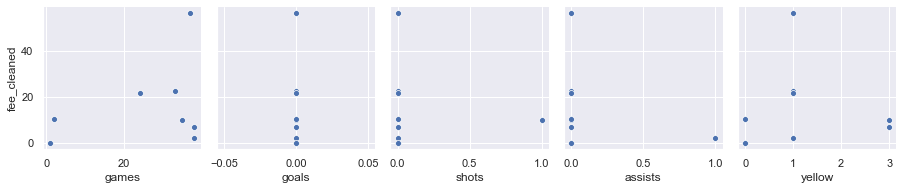

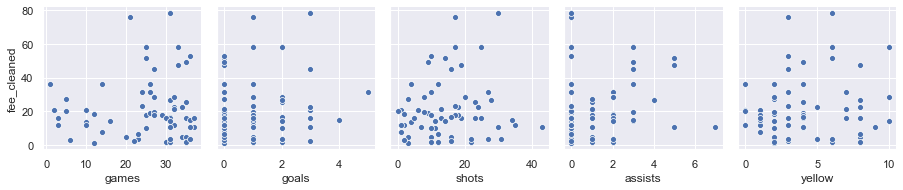

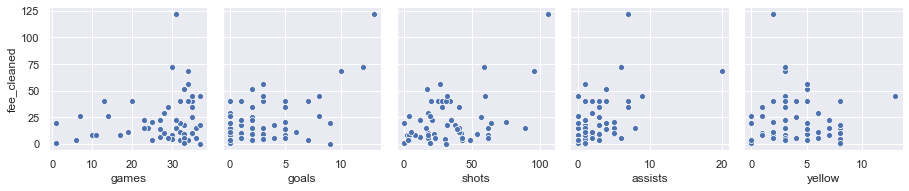

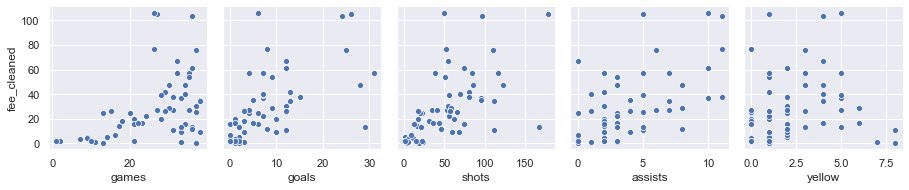

In [37]:
for dataframe in df_li:
    sns.pairplot(
        dataframe,
        x_vars=['games', 'goals', 'shots', 'assists', 'yellow'],
        y_vars=['fee_cleaned'])

Note como o valor de transferência (*fee_cleaned*) para goleiros não possui relação significativa com as variáveis preditoras que escolhemos. Isso já era de se esperar, afinal as métricas que estamos usando (*goals, assists, shots...*) não são boas preditoras do desempenho de um goleiro. 

Vendo isso, podemos já descartar a ideia de escrevermos um modelo para os goleiros usando essas variáveis preditoras.

Vamos agora olhar para as distribuições das variáveis preditoras.

In [38]:
len(df_li[0].columns)

15

In [39]:
def dist_graphs(dataframe, titulo):
    # Cria Subplots
    rows = 3; columns = 5

    fig, axs = plt.subplots(rows, columns,  figsize=(24, 12), constrained_layout=True)

    Xs = dataframe.columns 

    count = 0
    for i in range(rows):
        for j in range(columns):
            axs[i][j].hist(dataframe[Xs[count]], density=True)
            axs[i][j].set_xlabel(Xs[count], fontsize=18)
            
            count += 1
            
    fig.suptitle(titulo, fontsize=25)
    
    return

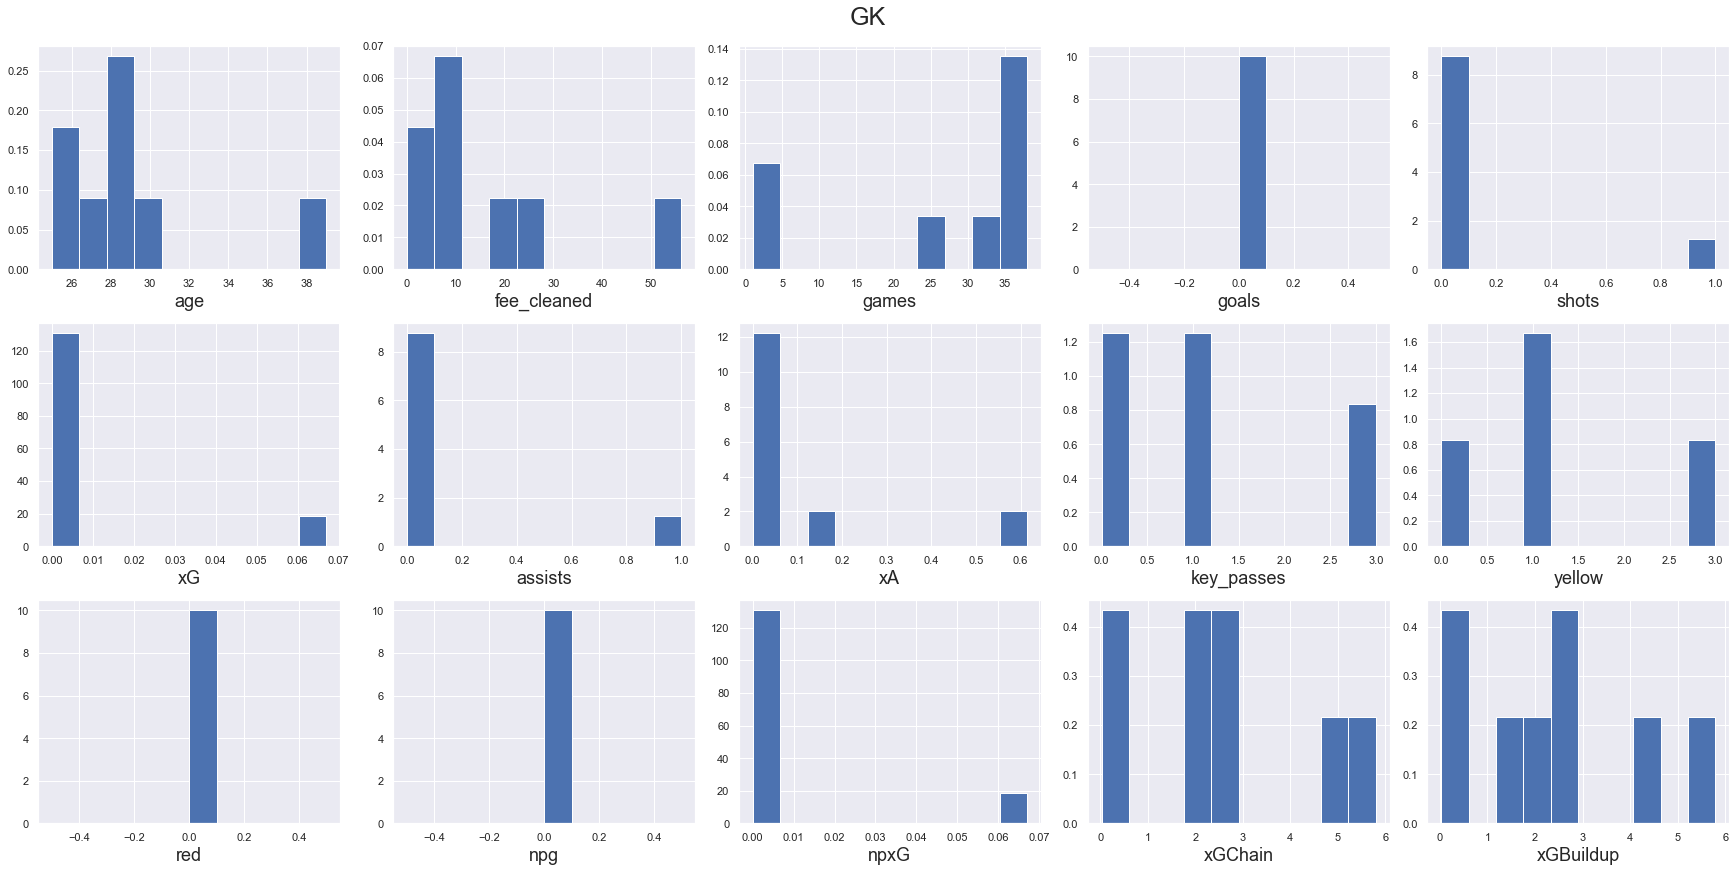

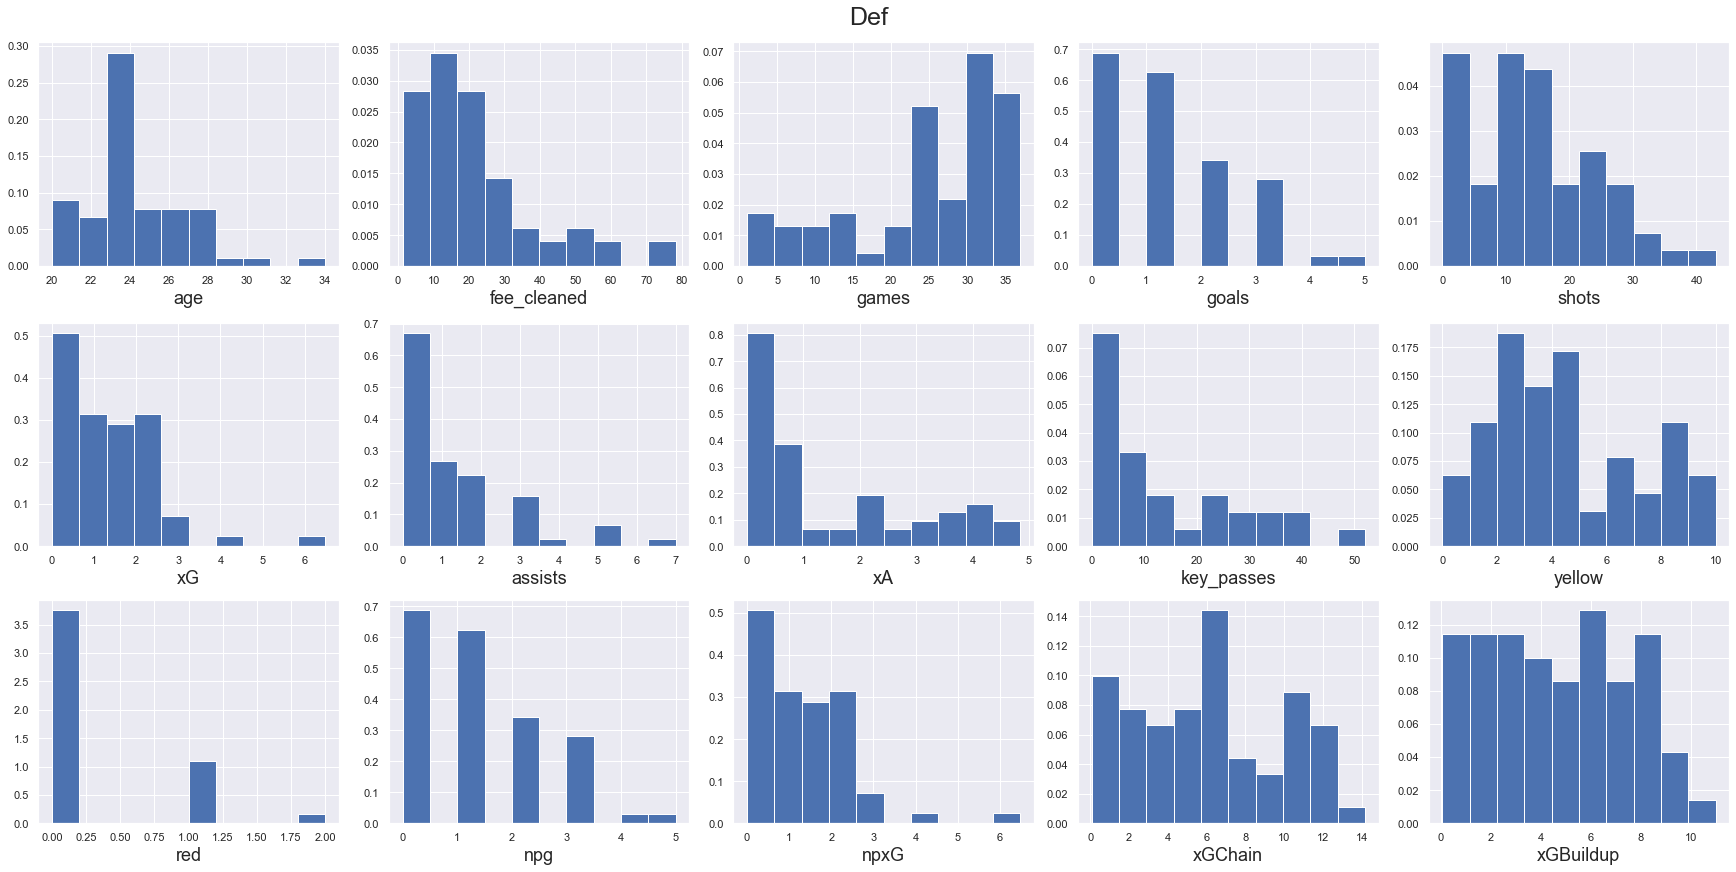

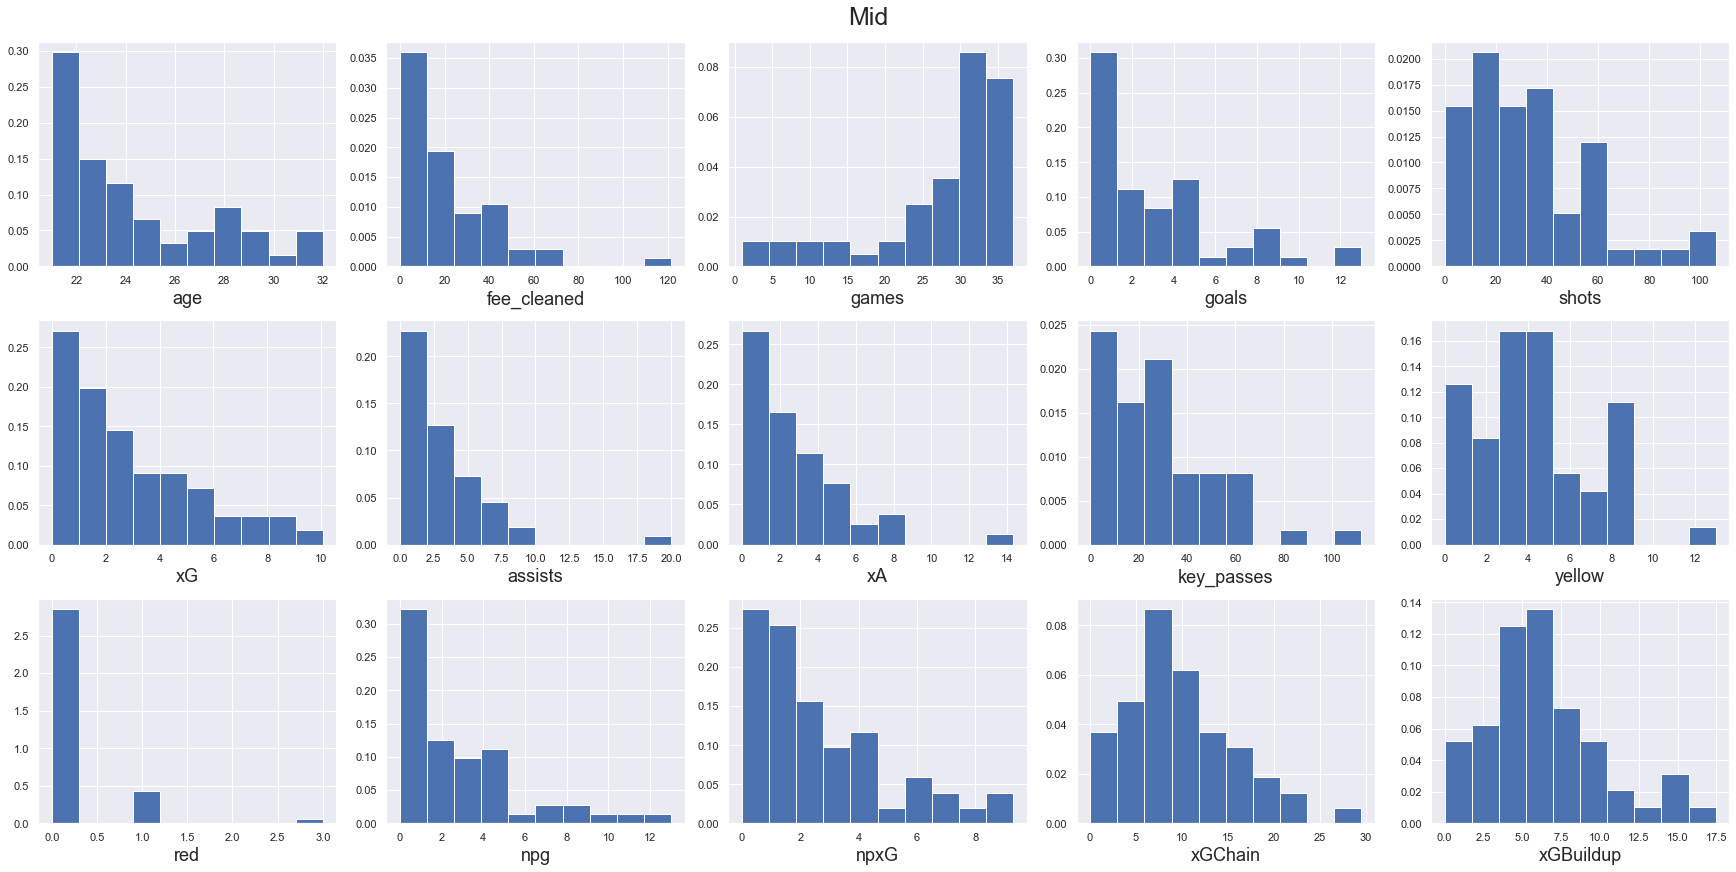

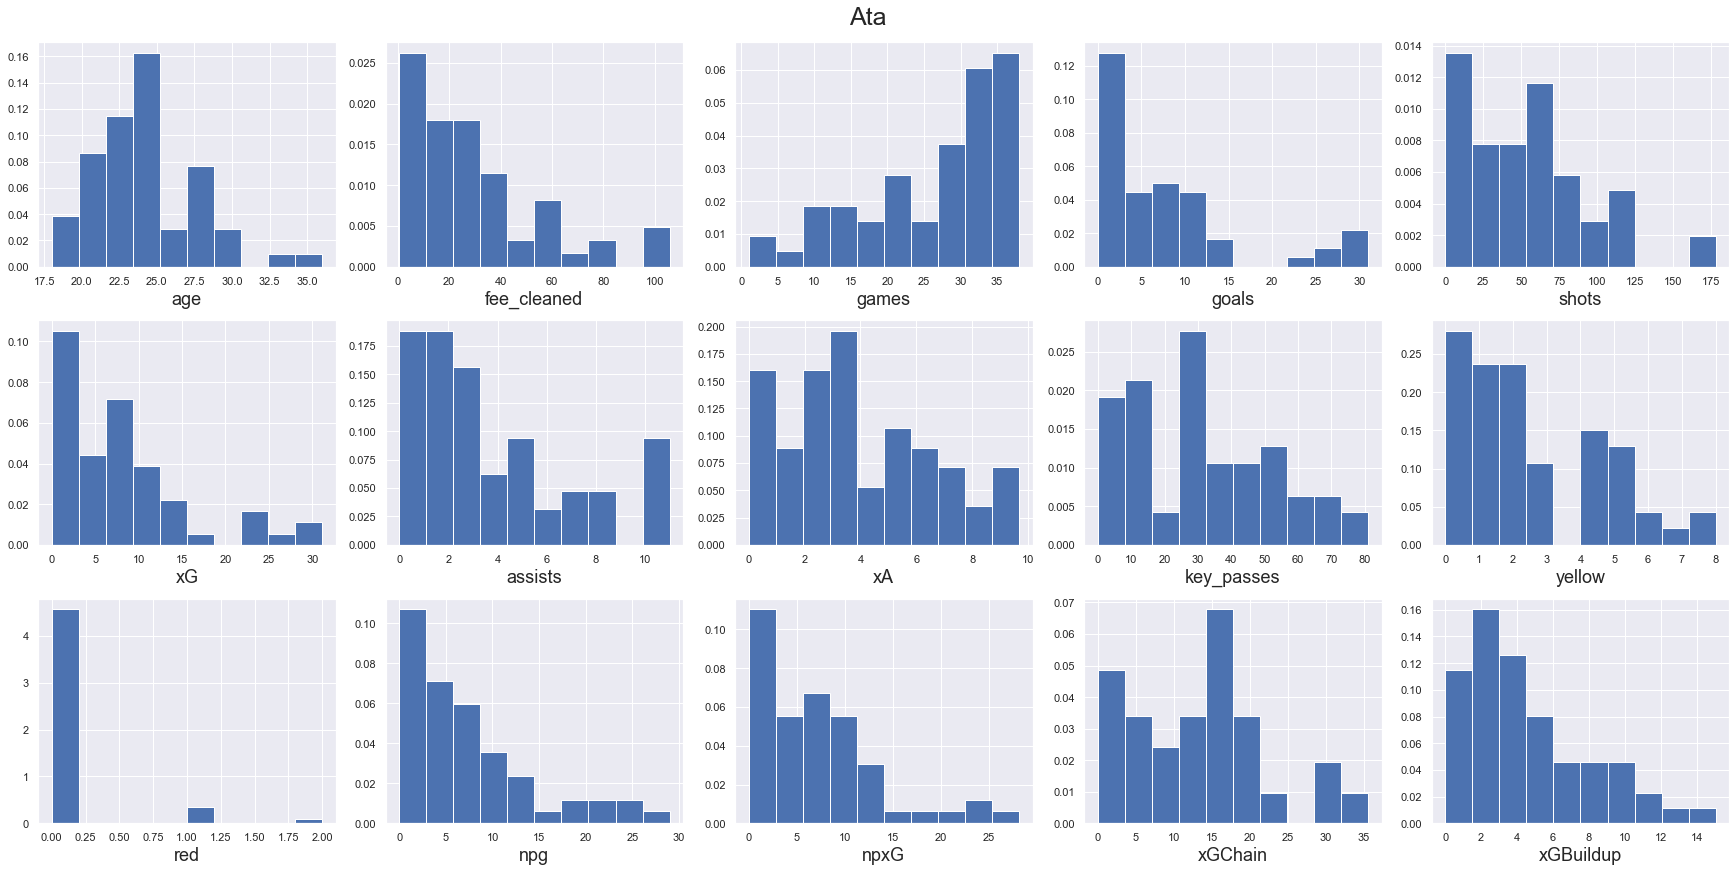

In [40]:
for key in dict_df_li:
    dist_graphs(dict_df_li[key], key)

Note que interessante as distribuições para atacantes e meio campistas (as distribuições para goleiros não são relevantes e para defensores não vamos relações claras).

Nas distribuições para meio-campistas vemos claras tendências. Por exemplo, a distribuição de assistências mostra que a probabilidade de encontrar um jogador com certo número de assistências decai exponencialmente à medida que o número de assistências aumenta, assim como a distribuição de xG. No entanto, as distribuições de xGChain e xGBuildup parecem ter um comportamento mais próximo de uma curva Normal.

Enquanto isso, as distribuições para atacantes parecem dividir os atacantes em dois grupos. Note como muitos atacantes possuem baixos fatores de npxG enquanto poucos possuem valores altos. O mesmo parece ocorrer na contagem de gols, xA e xGBuildup. 

Portanto, pode ser interessante avaliarmos se realmente podemos interpretar duas categorias distintas entre os atacantes.

# Classificação entre os Atacantes

Desejamos avaliar se realmente existem dois grupos distintos entre os atacantes. Para isso, vamos usar do algorítimo de K-Means para olharmos se conseguimos separar os atacantes em dois clusters distintos sem sobreposições.

In [41]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=2, random_state=0).fit(df_li[3])

Afim de avaliarmos a qualidade dessa clusterização temos diversos métodos. O primeiro deles é o método da silhueta, ideal para avaliar a qualidade do modelo K-Means.

Pontos cujos coeficientes forem próximos de 1 estão corretamente classificados e, mais próximos de pontos no seu próprio cluster do que dos pontos de outro cluster. Caso o coeficiente forneça um valor próximo a -1 o ponto estará classificado de forma equivocada, enquanto que um valor próximo de 0 indica que o ponto está equidistante de seu cluster para o outro cluster.

In [42]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

coeffs_for_each_point = silhouette_samples(df_li[3], k_means.labels_)
avg_coeff = silhouette_score(df_li[3], k_means.labels_)

In [43]:
print(f'Coeficiente de Silhueta para cada Pto: \n {coeffs_for_each_point}')

Coeficiente de Silhueta para cada Pto: 
 [ 0.38505372  0.21113933  0.66909897  0.65228147  0.16766357  0.38540202
  0.64269323  0.24790188  0.68394126  0.66424104  0.64826526  0.60368513
  0.66814701  0.39378972  0.64732241  0.33791659  0.38967375  0.47583062
  0.6679769   0.03172382  0.41075702  0.34148033  0.65266679  0.61912266
  0.16712805  0.33034031  0.24335239  0.62012531  0.2703478   0.36692741
  0.39862236  0.46510103 -0.04412303  0.42023598  0.63156458  0.6750996
  0.17139551  0.13137937  0.02291672  0.58010968  0.61508612  0.46953927
  0.51318514  0.47965242 -0.02736693  0.6667619   0.14122834  0.35479389
  0.1942299   0.33543813  0.61064937  0.40983573  0.66799895  0.6187431
  0.64789708  0.27911167  0.16941859  0.32701549]


In [44]:
print(f'Valor Médio do Coeficiente de Silhueta: {avg_coeff}')

Valor Médio do Coeficiente de Silhueta: 0.4227847536247218


Pelo modelo inicial, parece que, de fato, somos capazes de classificar dois grupos distintos nos atacantes. No entanto, parece que esses grupos não são sem sobreposições, oque justifica um valor do coeficiente de silhueta não tão bom. 

Pode ser que através de outros modelos de clusterização, agora considerando sobreposições entre os clusters, forneçam uma classificação melhor. 

Vamos tentar um modelo de mistura com a função gaussiana para ver se melhoramos a classificação.

In [45]:
from sklearn import mixture

gmm_model = mixture.GaussianMixture(2).fit(df_li[3])

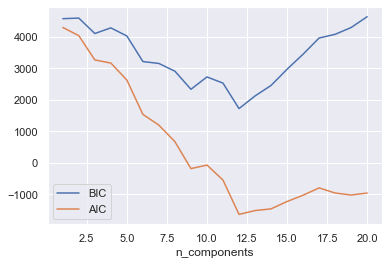

In [46]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(df_li[3]) for n in n_components]

plt.plot(n_components, [m.bic(df_li[3]) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df_li[3]) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

Note que pelas curvas BIC e AIC vemos que um número natural de clusters na verdade seria próximo aos 11 clusters (mínimo das curvas) muito diferente da nossa proposta de duas categorias entre os atacantes.

Na verdade, temos 11 categorias diferentes. 

Devido ao grande número de clusters seria difícil uma interpretação do que eles representam na vida real. Por isso não vamos dar continuídade ao processo de clusterização.

# Redução da Dimensionalidade

Devido ao grande número de variáveis preditoras que coletamos, para que possamos estudar melhor as relações entre as variáveis e entender quais são mais relevantes faz sentido aqui usarmos da Análise dos Componentes Principais (PCA).

O primeiro passo antes de avaliarmos se podemos, de fato, usar a PCA envolve a normalização das variáveis, para garantir que as diferentes unidades não vão afetar o peso dos fatores.

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [48]:
# lista de data frames normalizados
df_li_scaled = []

for dataframe in df_li:
    scaler.fit(dataframe.drop('fee_cleaned', axis=1))

    df_li_scaled.append(scaler.transform(dataframe.drop('fee_cleaned', axis=1)))

Agora, precisamos avaliar a adequação do conjunto de dados através do teste de esfericidade de Barlett e da estatística KMO.

In [49]:
# teste de Barlett
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

for dataframe in df_li_scaled:
    chi_square_value, p_value = calculate_bartlett_sphericity(dataframe)
    print(f'Chi Square: {chi_square_value} / P Value: {p_value}')

C:\Users\User\anaconda3\lib\site-packages\factor_analyzer\utils.py:92: RuntimeWarning: invalid value encountered in true_divide
  x = (x - x.mean(0)) / x.std(0)
C:\Users\User\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\User\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\User\anaconda3\lib\site-packages\factor_analyzer\factor_analyzer.py:111: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


Chi Square: nan / P Value: nan
Chi Square: nan / P Value: nan
Chi Square: 1111.889378067088 / P Value: 3.135847737092145e-175
Chi Square: 1319.51427512186 / P Value: 5.175894299182174e-217


Como podemos ver, pelos testes estatísticos apenas os dados para meio-campistas e atacantes são passíveis de usarmos dos Componentes Principais.

Os resultados 'nan' para os outros dados indicam variância zero entre as métricas.

In [50]:
# PCA model
from sklearn.decomposition import PCA

In [51]:
for dataframe in df_li_scaled[2:]:
    model = PCA(n_components=14).fit(dataframe)
    print(model.explained_variance_)
    print('\n')

[7.93927299e+00 2.04541033e+00 1.15365482e+00 1.07145201e+00
 7.46020768e-01 4.82286820e-01 3.01156294e-01 1.78762042e-01
 1.30838342e-01 1.02092311e-01 6.96309336e-02 3.08559346e-02
 5.49431520e-03 2.33134972e-03]


[7.98065509e+00 2.23739769e+00 1.07020857e+00 9.28607055e-01
 7.19206344e-01 5.41279604e-01 2.87963708e-01 1.77423696e-01
 1.33071544e-01 9.39922325e-02 3.79530410e-02 3.26801654e-02
 4.81433471e-03 3.60958831e-04]




Note que para os meio-campistas tivemos **4** fatores com autovalores maiores que 1.0, enquanto que para os atacantes apenas **3** fatores foram relevantes (critério do valor latente).

In [52]:
num_factors = [4, 3]

count = 0
for dataframe in df_li_scaled[2:]:
    model = PCA(n_components=num_factors[count]).fit(dataframe)
    
    print(f'Porcentagem da variância nos dados explicada pela escolha de fatores: {np.sum(model.explained_variance_ratio_ * 100)} %')
    
    count += 1

Porcentagem da variância nos dados explicada pela escolha de fatores: 85.62709975551488 %
Porcentagem da variância nos dados explicada pela escolha de fatores: 79.24025825760484 %


Com o uso dos fatores, os nossos dados podem ser escritos nos DataFrames onde as colunas agora são os fatores.

In [53]:
# novos dados após a fatorização
df_li_pca = []

for i in range(0, 2):
    df_li_pca.append(pd.DataFrame(data = PCA(num_factors[i]).fit_transform(X = df_li_scaled[i + 2]),
                                 columns = [f'PC{j}' for j in range(0, num_factors[i])]))

In [54]:
# adiciona a coluna fee_cleaned

for i in range(0, 2):
    df_li_pca[i]['fee_cleaned'] = df_li[i+2].reset_index(drop=True).fee_cleaned

In [55]:
df_li_pca[0].head()

,PC0,PC1,PC2,PC3,fee_cleaned
0,-2.748476,-0.526371,-0.912188,0.140348,6.30
1,9.197198,0.451585,2.062472,-2.963772,68.40
2,-0.872667,0.009677,1.581640,0.077203,10.35
3,1.249729,-1.021322,0.614622,1.370368,14.40
4,2.297312,0.202946,-0.305083,0.099457,9.54


# Análise de Regressão

Agora podemos realizar a modelagem dos nossos conjuntos de dados.

O primeiro passo para isso envolve separar nossos dados em um conjunto de treino e um de teste, de forma que possamos avaliar a eficácia do modelo de forma consistente

In [56]:
from sklearn.model_selection import train_test_split

Xtest = []; Xtrain = []
ytest = []; ytrain = []

for dataframe in df_li_pca:
    x0, x1, y0, y1 = train_test_split(dataframe.drop(['fee_cleaned'], axis=1), dataframe.fee_cleaned, random_state = 0)
    
    Xtrain.append(x0.reset_index(drop=True)); Xtest.append(x1.reset_index(drop=True))
    ytrain.append(y0.reset_index(drop=True)); ytest.append(y1.reset_index(drop=True))

Após a estruturação dos nossos conjuntos de teste e treino podemos tentar um modelo de regressão linear como um primeiro teste.

In [57]:
# linear regression with statsmodels package
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

In [58]:
# subrotina para escrever a formula de regressao y~x1+x2+x3...
def lm_formula_creation(X, y):
    f_string = '~'
    for i in X.columns:
        f_string += i + '+'
    
    return y + f_string[:-1]

In [59]:
# subrotina para realizar uma regressão linear e printar as estatísticas para o diagnóstico
def ols_regression(X, y):
    # Cria Subplots
    rows = 1; columns = 2

    fig, axs = plt.subplots(rows, columns,  figsize=(18, 6), constrained_layout=True)


    lm_model = ols(formula=lm_formula_creation(X, 'fee_cleaned'),
                   data=pd.concat([X, y], axis=1)).fit()
    
    #view model summary
    print(lm_model.summary())
    
    #perform Bresuch-Pagan test
    names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    test = sms.het_breuschpagan(lm_model.resid, lm_model.model.exog)

    print(f'\n F p-value Teste Breusch-Pagan de Heterocedasticidade: {test[-1]}')

    #test Shapiro-Francia for normality
    shapiro_stat, shapiro_p_value = stats.shapiro(lm_model.resid)
    
    print(f'\n p-value Teste Shapiro-Francia de Normalidade dos Resíduos: {shapiro_p_value}')

    # residuos
    axs[0].plot(lm_model.resid, 'bo'); axs[0].set_title('Residuos')
    
    # QQ-plot
    stats.probplot(lm_model.resid, dist="norm", plot=axs[1])
    
    return

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     4.826
Date:                Sat, 29 Jan 2022   Prob (F-statistic):            0.00321
Time:                        13:58:59   Log-Likelihood:                -175.02
No. Observations:                  41   AIC:                             360.0
Df Residuals:                      36   BIC:                             368.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.8323      2.903      7.520      0.0

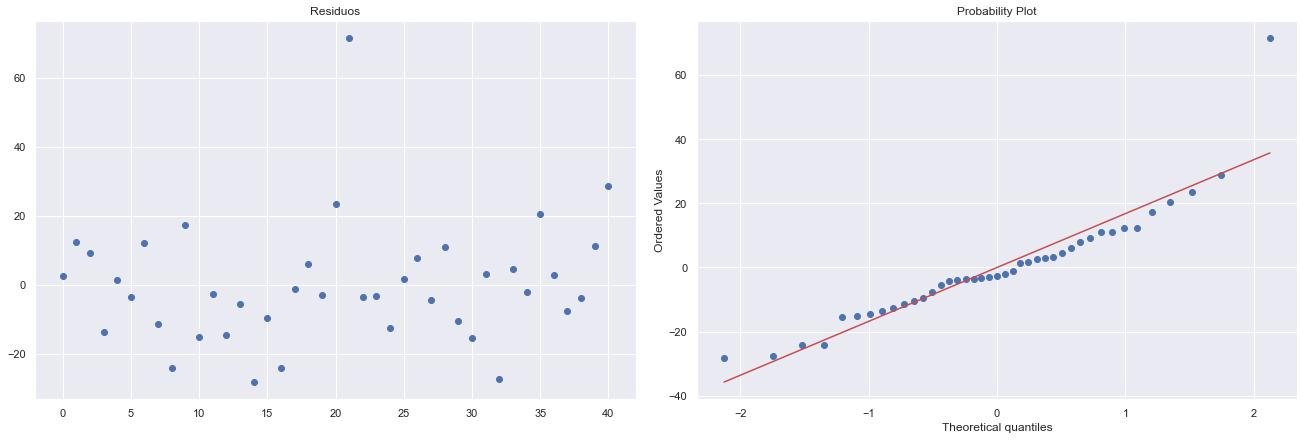

In [60]:
# regressao para os meio-campistas
ols_regression(Xtrain[0], ytrain[0])

Primeiramente, pelo teste F vemos que pelo menos um dos $\beta$ é statisticamente diferente de zero. Podemos avaliar a significância de cada $\beta$ através do teste T. Note que pelos p-values do teste T, apenas o primeiro fator *PCO* e o intercepto são estatisticamente significantes.

Além disso, o diagnóstico dos resíduos permite-nos concluir que o modelo linear é válido nessa situação. Afinal, pelo teste de Breusch-Pagan podemos verificar a homocedasticidade dos dados assim como a aderência à normalidade dos resíduos pelo teste Shapiro-Francia.

Apesar disso, o modelo não é capaz de capturar um fator muito grande da variância, como podemos verificar pelo valor do $R^2 = 0.35$.

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     10.18
Date:                Sat, 29 Jan 2022   Prob (F-statistic):           4.39e-05
Time:                        13:59:02   Log-Likelihood:                -183.90
No. Observations:                  43   AIC:                             375.8
Df Residuals:                      39   BIC:                             382.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.3656      2.814      9.724      0.0

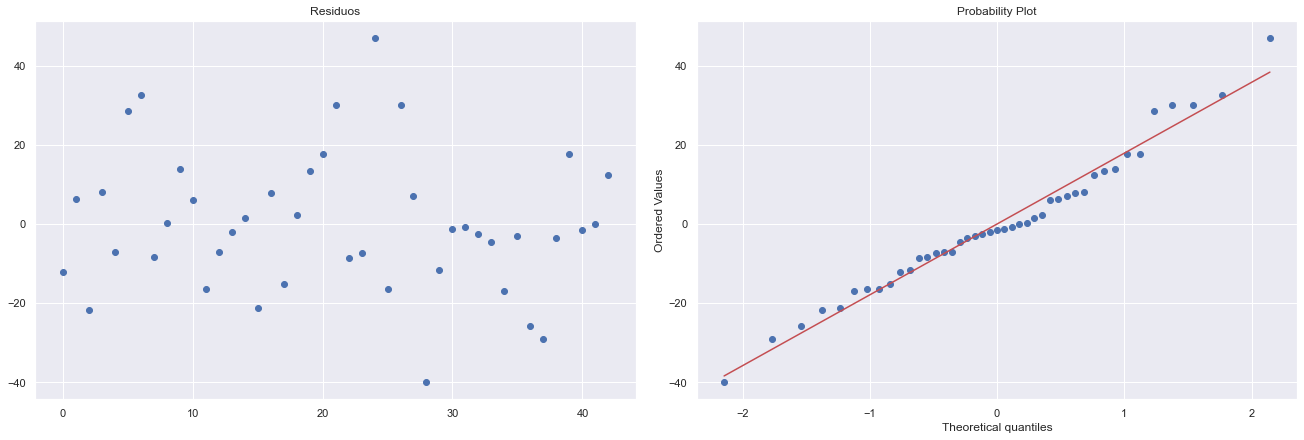

In [61]:
# regressao para os atacantes
ols_regression(Xtrain[1], ytrain[1])

Novamente, pelo teste F vemos a significância de pelo menos um dos $\beta$'s, enquanto que pelos testes T conferimos a significância dos $\beta$'s apenas do *PCO* e do intercepto.

Através do disgnóstico dos resíduos podemos concluir que o modelo linear não é adequado para os dados nesse caso, uma vez que os resíduos não foram aderentes à normalidade (Shapiro-Francia).

Afim de obtermos um modelo capaz de capturar uma maior variância vamos tentar realizar uma transformação de Box-Cox na variável y.

In [71]:
# transform training data & save lambda value
box_cox_y = []; box_cox_lambda = []

for dataframe in ytrain:
    fitted_data, fitted_lambda = stats.boxcox(dataframe)
    
    box_cox_y.append(pd.Series(fitted_data, name='fee_cleaned')); box_cox_lambda.append(pd.Series(fitted_lambda), name='fee_cleaned')

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     12.21
Date:                Sat, 29 Jan 2022   Prob (F-statistic):           8.93e-06
Time:                        14:38:18   Log-Likelihood:                -94.859
No. Observations:                  43   AIC:                             197.7
Df Residuals:                      39   BIC:                             204.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7238      0.355     16.131      0.0

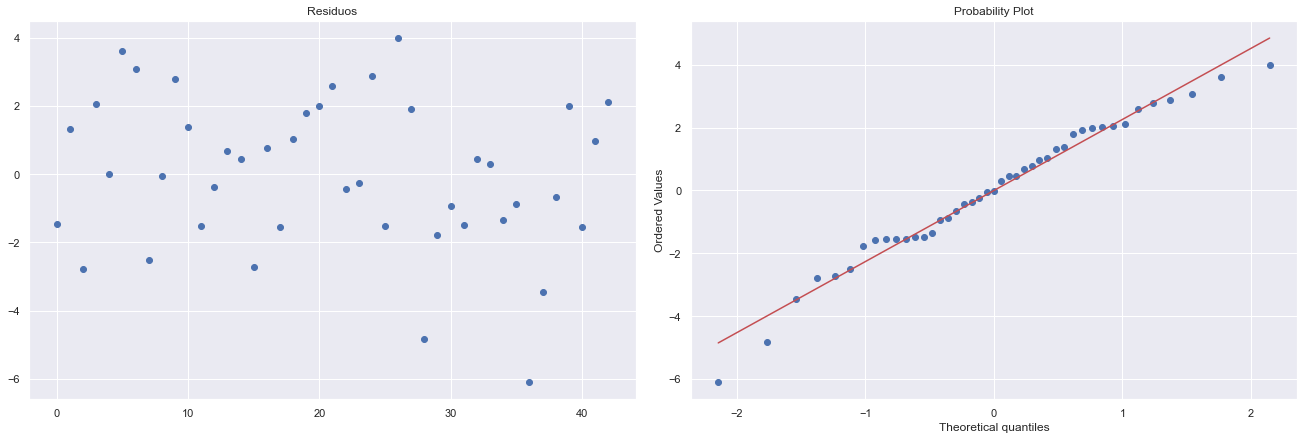

In [73]:
# regressao para os meio-campistas
ols_regression(Xtrain[0], box_cox_y[0])

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     10.18
Date:                Sat, 29 Jan 2022   Prob (F-statistic):           4.39e-05
Time:                        14:41:49   Log-Likelihood:                -183.90
No. Observations:                  43   AIC:                             375.8
Df Residuals:                      39   BIC:                             382.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.3656      2.814      9.724      0.0

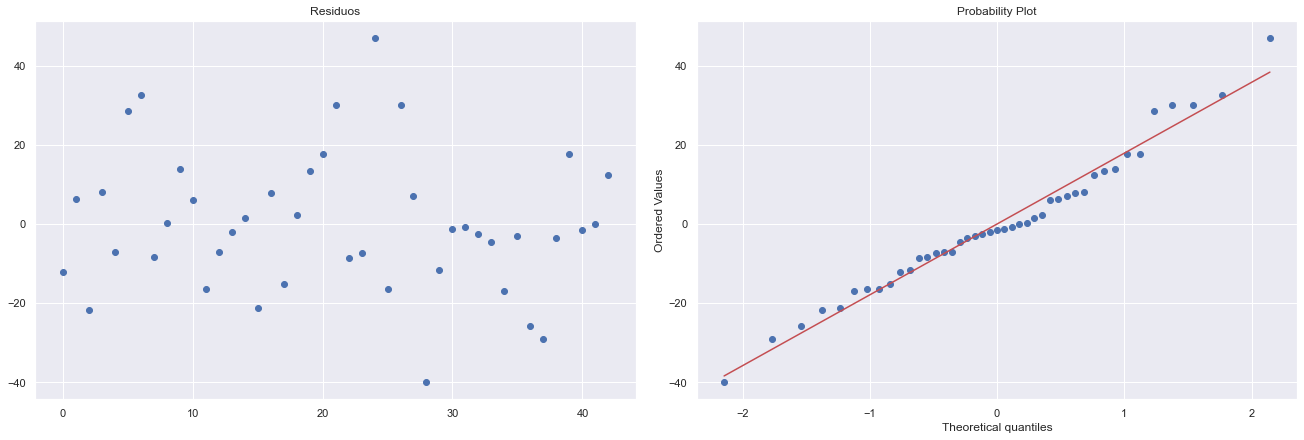

In [74]:
# regressao para os atacantes
ols_regression(Xtrain[1], box_cox_y[1])

Como podemos ver, a transformação de box-cox na variável y não foi capaz de melhorar nosso modelo e falhou nos testes de normalidade dos resíduos e homocedasticidade.

Portanto, o único modelo de regressão que se mostrou adequado foi o modelo para os meio-campistas. Após o procedimento step-wise temos como modelo final:

                            OLS Regression Results                            
Dep. Variable:            fee_cleaned   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     18.41
Date:                Sat, 29 Jan 2022   Prob (F-statistic):           0.000114
Time:                        14:55:18   Log-Likelihood:                -175.89
No. Observations:                  41   AIC:                             355.8
Df Residuals:                      39   BIC:                             359.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.7269      2.828      7.683      0.0

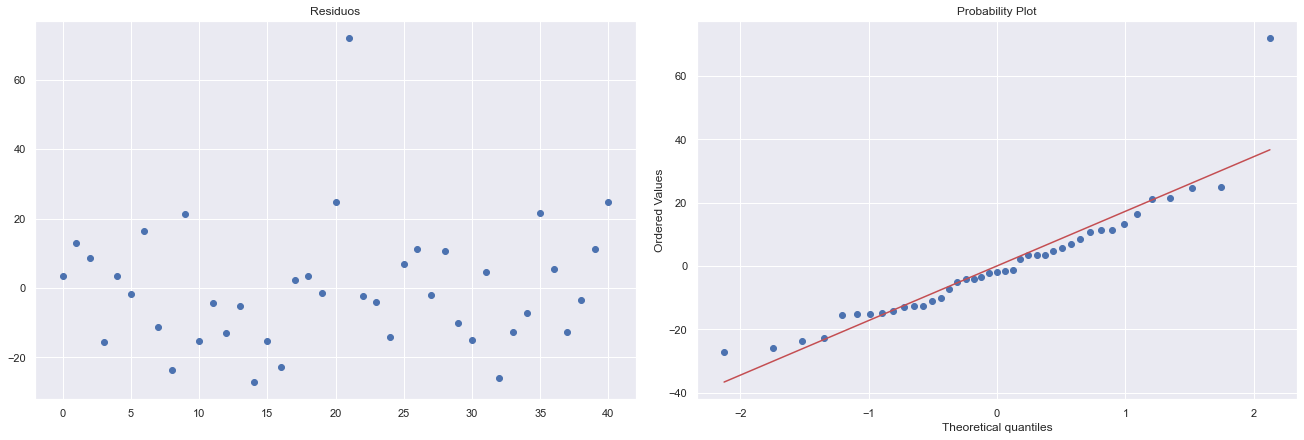

In [78]:
ols_regression(pd.DataFrame(Xtrain[0]['PC0']), ytrain[0])

# Conclusões

A ideia inicial de relacionar os valores de transferência com as estatísticas dos jogadores em suas temporadas anteriores era por si só uma proposta complicada. Afinal, sabemos que a transferência de um jogador envolve muito mais que apenas seu desempenho, envolve direitos de imagem, perspectivas de vendas de camisas, bônus para empresários, empresas de patrocínio... E como podemos verificar, apenas as métricas das temporadas não são boas preditoras do valor de venda  de um jogador.

Apenas para os meio-campistas fomos capazes de produzir um modelo de regressão consistente, mesmo que com um $R^2 = 0.35$ o modelo se mostrou válido após os diagnósticos. 

Vale ressaltar que a escolha dos conjuntos de dados impediu realizarmos uma análise dos defensores e goleiros, uma vez que os parâmetros não mostraram ter impacto real nos valores de venda. 

Do ponto de vista prático, essa proposta inicial de modelo poderia ser muito mais refinada (com mais dados da temporada, fatores externos como venda de camisas...) e ter sua relevância para os clubes ao avaliar contratar jogadores novos para seu elenco assim como na venda de seus próprios jogadores.